In [5]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import sys
import importlib
import pandas as pd

from utils_orbs.orb_paths import SetupPaths
import utils_orbs.readsubfHDF5Py3 as readSub
# from utils.read_group_cats import ReadCats
from utils_orbs.merger_trees import TraceMergerTree
from utils_orbs.readMergerHistoryFiles import FindHistory
from utils_orbs.vectorCorrection import vectorCorrection as vector

paths = SetupPaths()

In [6]:
plt.show();
plt.rcParams.update({'font.size':20,"xtick.direction":"in","ytick.direction":"in", 
                     "xtick.top":True, "ytick.right":True,"text.usetex":False,
                     "xtick.labelsize":18,"ytick.labelsize":18,
                     "xtick.minor.top":True, "ytick.minor.right":True,
                     "xtick.minor.visible": True,
                     "ytick.minor.visible": True})

In [7]:
# defining color palette for plotting
palette = {"low":"olive", "high":"salmon", 
           "difference":"#2C1D11", "difference2":"#464646"
          }    
        

In [8]:
low_all = {}
f = h5py.File(f"{paths.path_data}hail-mary/unique_orbits.hdf5",'r')
for key, val in f.items():
    low_all[key] = np.array(val)
f.close()

high_all = {}
f = h5py.File(f"{paths.path_data}big-bad/unique_orbits_massive.hdf5",'r')
for key, val in f.items():
    high_all[key] = np.array(val)
f.close()

f = h5py.File(f"{paths.path_data}snapshot_data.hdf5",'r')
convert = {}
for key, val in f.items():
    convert[key] = np.array(val)
f.close()

# Modify data

## Add PostInfall flag

In [72]:
# let's try to be smart about this ~ 
infall_arrays = np.array(np.triu(np.zeros((100,100))+1),dtype='bool')

low_all["PostInfall"] = infall_arrays[low_all['InfallSnapshot']]
high_all["PostInfall"] = infall_arrays[high_all['InfallSnapshot']]


## Create interpolated data

In [5]:
def create_interp(data, convert, num_samples=10000):
    # first, create interpolated conversion file so I have a list of redshifts and lookback times
    convert_interp = {}
    convert_interp["Lookback Time Interp"] = np.linspace(convert['Lookback Time'][0],convert['Lookback Time'][-1],num_samples)

    # interpolating Redshift along with Lookback Time:
    convert_interp["Redshift Interp"] = np.interp(convert_interp["Lookback Time Interp"][::-1], xp=convert['Lookback Time'][::-1], fp=convert['Redshift'][::-1])[::-1]

    # define the times that I am inputing with the data, and the interpolated 
    # time array where the interpolated data is returned
    times = convert['Lookback Time'][::-1]
    times_interp = convert_interp["Lookback Time Interp"][::-1]
    
    interp_dict = data.copy()
    interp_dict['Separations Interp'] = (np.zeros((len(data['Separations']),num_samples)))
    interp_dict['Separations Interp'].fill(np.nan)
    interp_dict['SeparationsComoving Interp'] = np.zeros((len(data['SeparationsComoving']),num_samples))
    interp_dict['SeparationsComoving Interp'].fill(np.nan)
    interp_dict['SeparationsScaled Interp'] = np.zeros((len(data['SeparationsScaled']),num_samples))
    interp_dict['SeparationsScaled Interp'].fill(np.nan)

    # complete interpolation of all separation values for each pair individually 
    # note that np.interp requires monotonically increasing x, hence the [::-1]
    for i in range(len(data['PairKey'])):
        seps = data['Separations'][i][::-1]
        comov = data['SeparationsComoving'][i][::-1]
        scaled = data['SeparationsScaled'][i][::-1]

        seps_interp = np.interp(times_interp, xp=times, fp=seps)[::-1]
        comov_interp = np.interp(times_interp, xp=times, fp=comov)[::-1]
        scale_interp = np.interp(times_interp, xp=times, fp=scaled)[::-1]

        interp_dict['Separations Interp'][i,:] = seps_interp
        interp_dict['SeparationsComoving Interp'][i,:] = comov_interp
        interp_dict['SeparationsScaled Interp'][i,:] = scale_interp
        
    
    return interp_dict, convert_interp


In [6]:
high_interp,convert_interp = create_interp(high_all, convert)
low_interp,convert_interp = create_interp(low_all, convert)

In [7]:
high_interp['Separations Interp'][0][500]

77.42363899719777

## Create conversions between interp and non-

In [8]:
ind_in_convert = []
for i in convert_interp['Lookback Time Interp']:
    ind_in_convert.append(np.where((i - convert["Lookback Time"])<=0)[0][-1])

ind_in_convert = np.array(ind_in_convert)
_, ind_in_interp = np.unique(ind_in_convert,return_index=True)

# Histogram of merger redshift

In [13]:
reds_high = high_all['MergeRedshift'][high_all['MergeFlag']]
reds_low = low_all['MergeRedshift'][low_all['MergeFlag']]

In [56]:
convert["Redshift"][::-1]

array([2.22044605e-16, 9.52166697e-03, 2.39744284e-02, 3.37243719e-02,
       4.85236300e-02, 5.85073228e-02, 7.36613847e-02, 8.38844308e-02,
       9.94018026e-02, 1.09869940e-01, 1.25759332e-01, 1.41876204e-01,
       1.52748769e-01, 1.69252033e-01, 1.80385262e-01, 1.97284182e-01,
       2.14425036e-01, 2.25988386e-01, 2.43540182e-01, 2.61343256e-01,
       2.73353347e-01, 2.97717685e-01, 3.10074120e-01, 3.28829724e-01,
       3.47853842e-01, 3.60687657e-01, 3.80167867e-01, 3.99926965e-01,
       4.19968942e-01, 4.40297849e-01, 4.60917794e-01, 4.81832943e-01,
       5.03047523e-01, 5.24565820e-01, 5.46392183e-01, 5.75980845e-01,
       5.98543288e-01, 6.21428745e-01, 6.44641841e-01, 6.76110411e-01,
       7.00106354e-01, 7.32636182e-01, 7.57441373e-01, 7.91068249e-01,
       8.16709979e-01, 8.51470901e-01, 8.86896938e-01, 9.23000816e-01,
       9.50531352e-01, 9.97294226e-01, 1.03551045e+00, 1.07445789e+00,
       1.11415056e+00, 1.15460271e+00, 1.20625808e+00, 1.24847261e+00,
      

In [57]:
convert["Redshift"][:5:-1]

array([2.22044605e-16, 9.52166697e-03, 2.39744284e-02, 3.37243719e-02,
       4.85236300e-02, 5.85073228e-02, 7.36613847e-02, 8.38844308e-02,
       9.94018026e-02, 1.09869940e-01, 1.25759332e-01, 1.41876204e-01,
       1.52748769e-01, 1.69252033e-01, 1.80385262e-01, 1.97284182e-01,
       2.14425036e-01, 2.25988386e-01, 2.43540182e-01, 2.61343256e-01,
       2.73353347e-01, 2.97717685e-01, 3.10074120e-01, 3.28829724e-01,
       3.47853842e-01, 3.60687657e-01, 3.80167867e-01, 3.99926965e-01,
       4.19968942e-01, 4.40297849e-01, 4.60917794e-01, 4.81832943e-01,
       5.03047523e-01, 5.24565820e-01, 5.46392183e-01, 5.75980845e-01,
       5.98543288e-01, 6.21428745e-01, 6.44641841e-01, 6.76110411e-01,
       7.00106354e-01, 7.32636182e-01, 7.57441373e-01, 7.91068249e-01,
       8.16709979e-01, 8.51470901e-01, 8.86896938e-01, 9.23000816e-01,
       9.50531352e-01, 9.97294226e-01, 1.03551045e+00, 1.07445789e+00,
       1.11415056e+00, 1.15460271e+00, 1.20625808e+00, 1.24847261e+00,
      

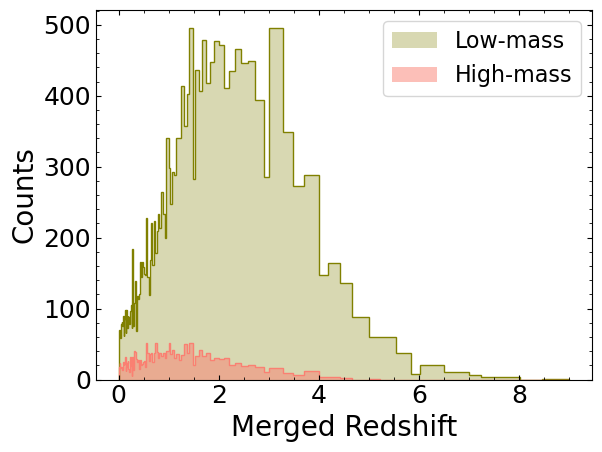

In [63]:
bins = convert["Redshift"][:5:-1]
vals_low,_ = np.histogram(reds_low,bins=bins)
vals_high,_ = np.histogram(reds_high,bins=bins)

plt.stairs(vals_low,edges=bins,color=palette['low'],alpha=0.3,fill=True,label="Low-mass")
plt.stairs(vals_high,edges=bins,color=palette['high'],alpha=0.5,fill=True,label="High-mass")

plt.stairs(vals_low,edges=bins,color=palette['low'],lw=1)
plt.stairs(vals_high,edges=bins,color=palette['high'],lw=1)

plt.ylabel("Counts")
plt.xlabel("Merged Redshift")
plt.legend(fontsize=16)
plt.show()

add the massive pairs to this and then make a few notes about how this follows/answers from the pair fraction evoltuion behavior found in the previous work

# Number of pairs

In [65]:
# take sep array, and replace nans with 0s, then call everything with non-0 separation a pair

zeroed_low = np.where(~np.isnan(low_all['Separations']),low_all['Separations'],0)

In [69]:
zeroed_low[100]

array([ 0.        ,  0.        , 36.04174153, 34.81861663, 33.33208044,
       31.31657467, 29.64973374, 25.96814217,  0.        , 14.09238442,
        8.40634018,  0.        ,  4.40245828,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [74]:
low_all['PostInfall'][0]

array([False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [76]:
is_pair_low[low_all["MergeFlag"]]

array([[False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       [False,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True, False, False],
       [False, False, False, ...,  True,  True, False],
       [False, False, False, ...,  True,  True, False]])

In [80]:
zeroed_low = np.where(~np.isnan(low_all['Separations']),low_all['Separations'],0)
is_pair_low = (zeroed_low!=0)
is_post_low = low_all['PostInfall']
is_both_low = is_pair_low&is_post_low

num_pairs_low = np.sum(is_pair_low,axis=0)
num_post_low = np.sum(is_both_low,axis=0)
num_mpairs_low = np.sum(is_pair_low[low_all["MergeFlag"]],axis=0)
num_mpost_low = np.sum(is_both_low[low_all["MergeFlag"]],axis=0)

In [85]:
zeroed_high = np.where(~np.isnan(high_all['Separations']),high_all['Separations'],0)
is_pair_high = (zeroed_high!=0)
is_post_high = high_all['PostInfall']
is_both_high = is_pair_high&is_post_high

num_pairs_high = np.sum(is_pair_high,axis=0)
num_post_high = np.sum(is_both_high,axis=0)
num_mpairs_high = np.sum(is_pair_high[high_all["MergeFlag"]],axis=0)
num_mpost_high = np.sum(is_both_high[high_all["MergeFlag"]],axis=0)

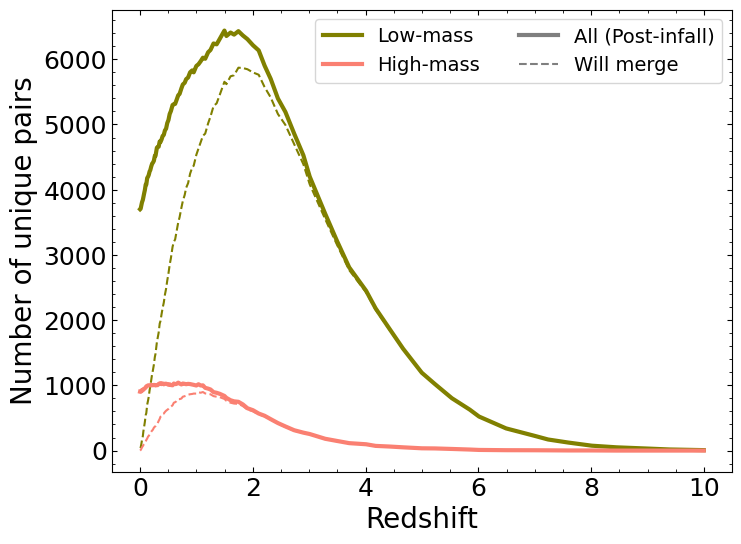

In [94]:
fig,ax = plt.subplots(figsize=(8,6))
plt.plot(convert["Redshift"][4:],num_post_low[4:],label='Low-mass',color=palette['low'],lw=3)
plt.plot(convert["Redshift"][4:],num_mpost_low[4:],color=palette['low'],lw=1.5,linestyle='dashed')

plt.plot(convert["Redshift"][4:],num_post_high[4:],label='High-mass',color=palette['high'],lw=3)
plt.plot(convert["Redshift"][4:],num_mpost_high[4:],color=palette['high'],lw=1.5,linestyle='dashed')




# plt.plot(0,0,label='Total',linestyle='dashed',color="tab:grey",lw=2)
# plt.plot(0,0,label='Same Group',linestyle='dotted',color="tab:grey",lw=3)
plt.plot(0,0,label='All (Post-infall)',color="tab:grey",lw=3)
plt.plot(0,0,label='Will merge',color="tab:grey",lw=1.5,linestyle='dashed')

# plt.plot(snap_dict["Redshift"],0.25/(1+(snap_dict["Redshift"]))**2.,label=r"$C(1+z)^{-2}$",color="tab:olive")
# plt.ylim(top=0.06)
# plt.xlim(right=10)
plt.legend(fontsize=14,ncol=2)
# plt.title("Number of unique pairs")
plt.xlabel("Redshift")
plt.ylabel("Number of unique pairs")
plt.savefig("../../plots/bet-on-it/3_number_pairs.png")
plt.show()


# Time until merger

What if instead of taking all halos that merge at the given redshift, I FIRST take all the halos that are in the right separation bin at z=4 and calculate the average time until merger for only those halos? 

In [215]:
times_til_merger = {}
for dat,nam in [[low_all,"low"],[high_all,"high"]]:

    postinfall = dat["PostInfall"][dat['MergeFlag']]
    seps = dat['Separations'][dat['MergeFlag']]
    mergesnap = dat['MergeSnapshot'][dat['MergeFlag']]

    post_infall_seps = np.where(postinfall, seps, 0)
    in_bin = (post_infall_seps<50)&(post_infall_seps>10)

    times_til_merger[nam] = {}

    for i in range(len(in_bin[0])):
        merger_snaps = mergesnap[in_bin[:,i]]
        merger_lbt = convert["Lookback Time"][merger_snaps]
        times_til_merger[nam][i] = convert["Lookback Time"][i] - merger_lbt
    

In [224]:
counts_low = np.array([len(times_til_merger["low"][i]) for i in range(100)])
counts_high = np.array([len(times_til_merger["high"][i]) for i in range(100)])

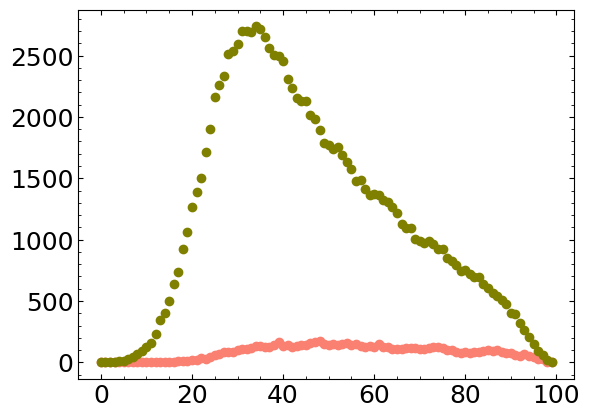

In [226]:
plt.scatter(convert['Snapshot'],counts_high,color=palette['high'])
plt.scatter(convert['Snapshot'],counts_low,color=palette['low'])

In [310]:
num_mpost_low

array([   0,    0,    1,    1,    7,   17,   31,   50,   75,  123,  170,
        224,  340,  522,  628,  802, 1018, 1190, 1555, 1848, 2160, 2427,
       2767, 3159, 3549, 4084, 4391, 4698, 4993, 5161, 5415, 5574, 5763,
       5798, 5847, 5866, 5871, 5755, 5739, 5619, 5655, 5458, 5325, 5281,
       5122, 5017, 4860, 4827, 4728, 4632, 4535, 4368, 4338, 4246, 4101,
       4029, 3920, 3825, 3724, 3577, 3499, 3349, 3238, 3200, 3125, 2951,
       2849, 2716, 2608, 2482, 2390, 2268, 2187, 2089, 1984, 1948, 1807,
       1720, 1663, 1484, 1434, 1313, 1225, 1181, 1081,  982,  929,  823,
        771,  704,  574,  544,  436,  378,  297,  222,  164,  110,   45,
          0])

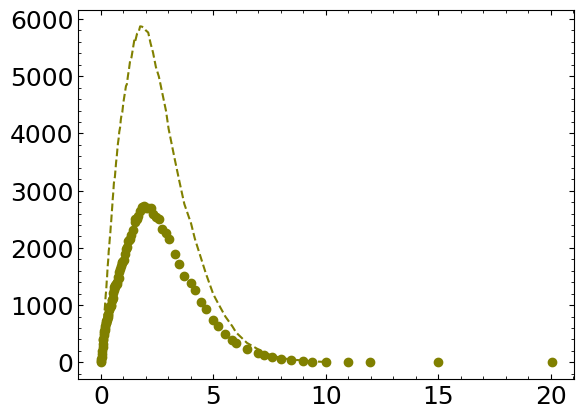

In [311]:
# plt.scatter(convert['Redshift'],counts_high,color=palette['high'])
plt.scatter(convert['Redshift'],counts_low,color=palette['low'])
plt.plot(convert["Redshift"][4:],num_mpost_low[4:],color=palette['low'],lw=1.5,linestyle='dashed')


In [232]:
meds_low, qs_low = [], []
meds_high, qs_high = [], []

for i in range(100):
    times = times_til_merger["low"][i]

    if len(times) == 0:
        meds_low.append(0)
        qs_low.append([0,0])
        
    else:
        med = np.median(times)
        meds_low.append(med)
        
        qs = np.quantile(times,np.array([0.25,0.75]))
        qs_low.append(qs)
        
        
    times = times_til_merger["high"][i]

    if len(times) == 0:
        meds_high.append(0)
        qs_high.append([0,0])
        
    else:
        med = np.median(times)
        meds_high.append(med)
        
        qs = np.quantile(times,np.array([0.25,0.75]))
        qs_high.append(qs)
        
meds_low = np.array(meds_low)
qs_low = np.array(qs_low)
meds_high = np.array(meds_high)
qs_high = np.array(qs_high)


(-0.09220723034001842, 2.5)

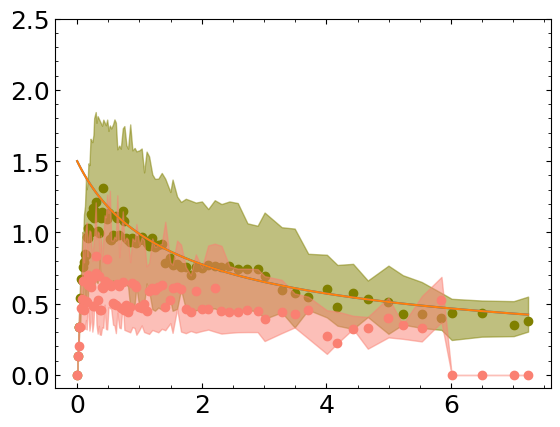

In [280]:
ind_cut = 10
reds = convert['Redshift'][ind_cut:]

plt.scatter(reds,meds_low[ind_cut:],color=palette['low'])
plt.fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)

plt.scatter(reds,meds_high[ind_cut:],color=palette['high'])
plt.fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)

plt.plot(reds,1.5/(1+reds)**0.6)
plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2.5)



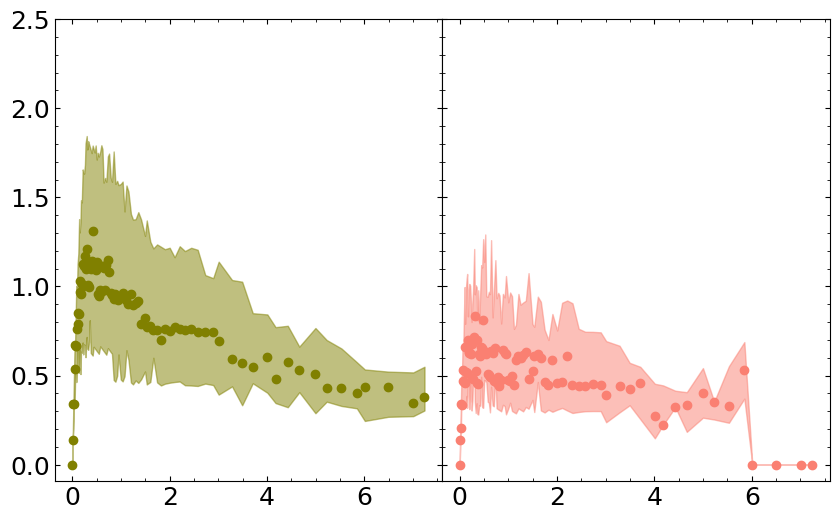

In [289]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.0,
                                    "hspace":0.0})


ind_cut = 10
reds = convert['Redshift'][ind_cut:]

ax[0].scatter(reds,meds_low[ind_cut:],color=palette['low'])
ax[0].fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)

ax[1].scatter(reds,meds_high[ind_cut:],color=palette['high'])
ax[1].fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)

# plt.plot(reds,1.5/(1+reds)**0.6)
# plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2.5)
plt.show()


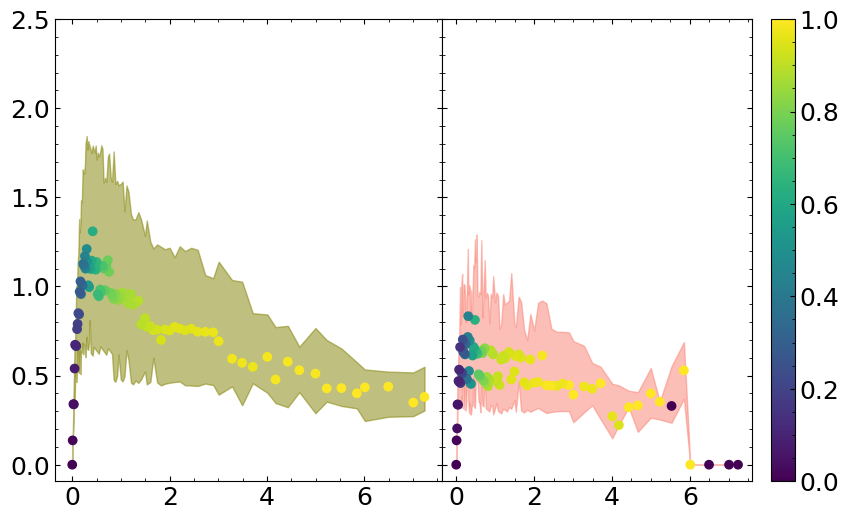

In [313]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.0,
                                    "hspace":0.0})


ind_cut_low = 10
ind_cut_low
reds = convert['Redshift'][ind_cut:]

ax[0].fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)
l = ax[0].scatter(reds,meds_low[ind_cut:],c=frac_low['Fraction'][ind_cut:])
# plt.colorbar(l)

ax[1].fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)
r = ax[1].scatter(reds,meds_high[ind_cut:],c=frac_high['Fraction'][ind_cut:])
plt.colorbar(r)
# plt.plot(reds,1.5/(1+reds)**0.6)
# plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2.5)
plt.show()


In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.0,
                                    "hspace":0.0})


ind_cut_low = 10
ind_cut_low
reds = convert['Redshift'][ind_cut:]

ax[0].fill_between(reds,qs_low[ind_cut:,0],qs_low[ind_cut:,1],color=palette['low'],alpha=0.5)
l = ax[0].scatter(reds,meds_low[ind_cut:],c=frac_low['Fraction'][ind_cut:])
# plt.colorbar(l)

ax[1].fill_between(reds,qs_high[ind_cut:,0],qs_high[ind_cut:,1],color=palette['high'],alpha=0.5)
ax[1].scatter(reds,meds_high[ind_cut:],c=frac_high['Fraction'][ind_cut:])
# plt.plot(reds,1.5/(1+reds)**0.6)
# plt.plot(reds,1.5/(1+reds)**0.6)

plt.ylim(top=2.5)
plt.show()


In [302]:
frac_high = pd.read_csv('../../data/big-bad/highmass_merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))
frac_low = pd.read_csv('../../data/hail-mary/merger_fraction.csv',names=np.array(["Snapshot","Fraction"]))


In [298]:
frac_low['Fraction'].shape

(100,)

In [320]:
[2]*5

[2, 2, 2, 2, 2]

In [336]:
# make the x and y arrays for the 2d histogram
x = []
y = []
for i in range(100):
    p = times_til_merger['low'][i]
    redshift = convert['Redshift'][i]
    if len(p) == 0:
        continue
    else:
        xadd = [redshift]*len(p)
        x.extend(xadd)
        y.extend(p)
        
x = np.array(x)
y = np.array(y)

In [348]:
# make the x and y arrays for the 2d histogram
xh = []
yh = []
for i in range(100):
    p = times_til_merger['high'][i]
    redshift = convert['Redshift'][i]
    if len(p) == 0:
        continue
    else:
        xadd = [redshift]*len(p)
        xh.extend(xadd)
        yh.extend(p)
        
xh = np.array(xh)
yh = np.array(yh)

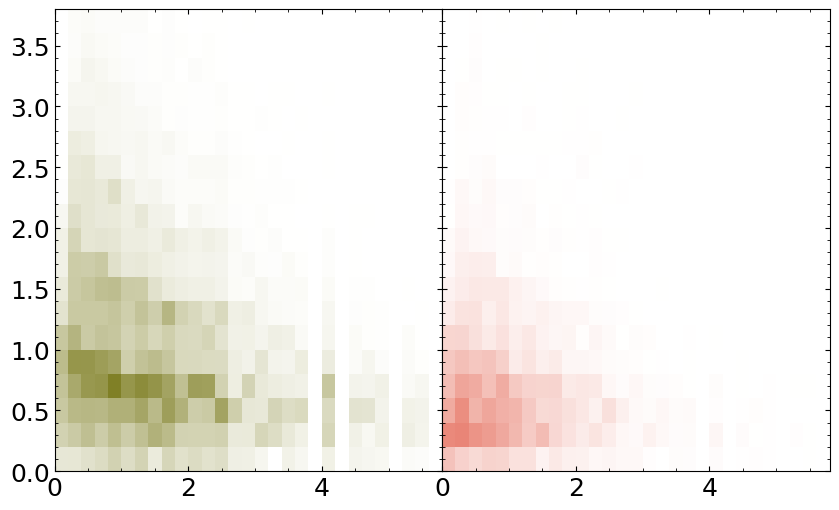

In [367]:
fig, ax = plt.subplots(1, 2, figsize=(10,6),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1],
                                    'wspace': 0.0,
                                    "hspace":0.0})

one = ax[0].hist2d(x,y,bins=(np.arange(0,6,0.2),np.arange(0,4,0.2)),cmap=green_map)
two = ax[1].hist2d(xh,yh,bins=(np.arange(0,6,0.2),np.arange(0,4,0.2)),cmap=pink_map)
# plt.scatter(reds,meds_low[ind_cut:],color=palette['low'])

# plt.colorbar(one)
plt.show()

In [357]:
from matplotlib.colors import ListedColormap


In [366]:
N = 256
vals = np.ones((N, 4))
vals[:, 0] = np.linspace(128/256, 1, N)[::-1]
vals[:, 1] = np.linspace(128/256, 1, N)[::-1]
vals[:, 2] = np.linspace(38/256, 1, N)[::-1]
green_map = ListedColormap(vals)


vals = np.ones((N, 4))
vals[:, 0] = np.linspace(234/256, 1, N)[::-1]
vals[:, 1] = np.linspace(134/256, 1, N)[::-1]
vals[:, 2] = np.linspace(119/256, 1, N)[::-1]
pink_map = ListedColormap(vals)


In [353]:
x.shape

(117528,)

In [330]:
y.shape


(117528,)


# Time til merger function

one last thing I want to try, is to bin at the lower redshifts. so anywhere the redshift spacing is <0.2 or so, just bin it ~~~ 
so have a list of redshifts:
reds = np.arange(0,10,0.2)
^ and use those as the bounds for finding things in this small separation range

In [267]:
def time_til_merger(lower=10, upper=50):
    times_dict = {}
    for dat,nam in [[low_all,"low"],[high_all,"high"]]:

        postinfall = dat["PostInfall"][dat['MergeFlag']]
        seps = dat['Separations'][dat['MergeFlag']]
        mergesnap = dat['MergeSnapshot'][dat['MergeFlag']]

        post_infall_seps = np.where(postinfall, seps, 0)
        in_bin = (post_infall_seps<50)&(post_infall_seps>10)

        times_dict[nam] = {}

        for i in range(len(in_bin[0])):
            merger_snaps = mergesnap[in_bin[:,i]]
            merger_lbt = convert["Lookback Time"][merger_snaps]
            times_dict[nam][i] = convert["Lookback Time"][i] - merger_lbt


    meds_low, qs_low = [], []
    meds_high, qs_high = [], []

    for i in range(100):
        times = times_dict["low"][i]

        if len(times) == 0:
            meds_low.append(0)
            qs_low.append([0,0])

        else:
            med = np.median(times)
            meds_low.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_low.append(qs)


        times = times_til_merger["high"][i]

        if len(times) == 0:
            meds_high.append(0)
            qs_high.append([0,0])

        else:
            med = np.median(times)
            meds_high.append(med)

            qs = np.quantile(times,np.array([0.25,0.75]))
            qs_high.append(qs)

    mlow = np.array(meds_low)
    qlow = np.array(qs_low)
    mhigh = np.array(meds_high)
    qhigh = np.array(qs_high)
    
    return mlow, qlow, mhigh, qhigh, times_dict


In [269]:
mlow, qlow, mhigh, qhigh, times = time_til_merger()

<ErrorbarContainer object of 3 artists>

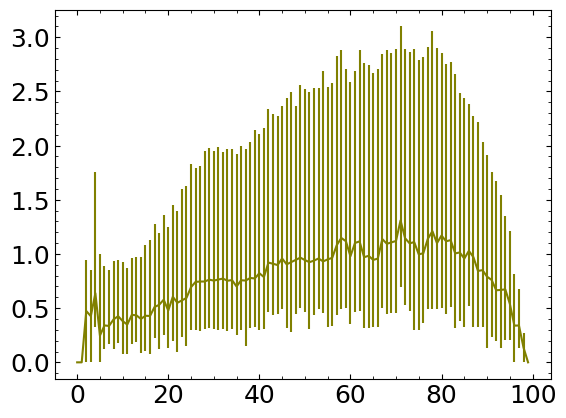

In [238]:
plt.errorbar(convert['Snapshot'],meds_low,yerr=qs_low.transpose(),color=palette['low'])
# plt.scatter(convert['Snapshot'],counts_low,color=palette['low'])

In [227]:
meds_low = np.array([np.median(times_til_merger["low"][i]) for i in range(100)] if )
meds_high = np.array([np.median(times_til_merger["high"][i]) for i in range(100)] if )

/home/u13/katiechambe/.conda/envs/tart/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/u13/katiechambe/.conda/envs/tart/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [102]:
low_all["PostInfall"][low_all['MergeFlag']].shape

(18513, 100)

In [109]:
low_all['Separations'][0]

array([        nan, 52.64222395, 45.36878377, 38.27446097, 27.25857981,
       19.04804291, 12.46017124,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [111]:
np.where(low_all["PostInfall"],low_all['Separations'],0).shape

(22213, 100)

In [113]:
np.where(low_all["MergeFlag"],post_infall_seps,0)

ValueError: operands could not be broadcast together with shapes (22213,) (22213,100) () 

In [132]:
sum(in_bin[:,0])

2

In [133]:
merger_snaps = low_all["MergeSnapshot"][in_bin[:,0]]

In [134]:
convert["Lookback Time"][merger_snaps]

array([12.95908235, 12.8709994 ])

In [135]:
convert["Lookback Time"][0]

13.623404302747057

In [178]:
low_all_postinfall = low_all["PostInfall"][low_all['MergeFlag']]
low_all_seps = low_all['Separations'][low_all['MergeFlag']]
low_all_mergesnap = low_all['MergeSnapshot'][low_all['MergeFlag']]



In [179]:
low_all_mergesnap.shape

(18513,)

In [185]:
post_infall_seps.shape

(18513, 100)

In [184]:
in_bin.shape

(18513, 100)

In [182]:
low_all_postinfall = low_all["PostInfall"][low_all['MergeFlag']]
low_all_seps = low_all['Separations'][low_all['MergeFlag']]
low_all_mergesnap = low_all['MergeSnapshot'][low_all['MergeFlag']]

post_infall_seps = np.where(low_all_postinfall,low_all_seps,0)
in_bin = (post_infall_seps<50)&(post_infall_seps>10)

In [ ]:
merger_snaps=

In [234]:
convert['Snapshot']

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [291]:
snapshotind = 20
len(interp_unique_low['Separations'][:,snapshotind])
print(np.where(interp_unique_low['Separations'][:,snapshotind]<50))
print(np.where(interp_unique_low['Separations'][:,snapshotind]>10))

in_bin = (interp_unique_low['Separations'][:,snapshotind]<50)&(interp_unique_low['Separations'][:,snapshotind]>10)&interp_unique_low['MergeFlag']

(array([    0,     1,     2, ..., 16100, 16402, 17330]),)
(array([   24,    40,    58, ..., 22208, 22209, 22210]),)


In [293]:
np.sum(in_bin)

1574

In [294]:
interp_unique_low['MergeSnapshot'][in_bin]

array([22, 22, 21, ..., 54, 51, 61], dtype=int32)

In [273]:
len(interp_unique_low['MergeSnapshot'][in_bin&interp_unique_low['MergeFlag']])

1575

In [278]:
np.mean(convert['Lookback Time'][20] - convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]])

0.864216701029149

In [276]:
convert['Lookback Time'][20]

12.33668348451083

In [255]:
interp_unique_low['Separations'][8]

array([35.81720415, 41.37461616, 42.91736058, 43.79651586, 47.65742725,
       46.7782339 , 43.36229777, 40.13599373, 37.72168994, 33.9416208 ,
       26.64278594, 20.98028812,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [297]:
convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]

array([], dtype=float64)

In [296]:
# first do it without the interpolated values & use ONLY the snapshot of interest
# next time do with interp and use some +/- value on either side of the redshift ~ 
mean_time_til, std_time_til = np.zeros((2,len(convert['Snapshot'])))

for i in convert['Snapshot']:
    in_bin = (interp_unique_low['Separations'][:,i]<50)&(interp_unique_low['Separations'][:,i]>10)&interp_unique_low['MergeFlag']
    
    
    merge_lbt = convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]
    time_to_merge = convert['Lookback Time'][i] - merge_lbt
    
    if 1==0:
        mean_til = np.NaN
        std_til = np.NaN
    else:
        mean_til = np.mean(time_to_merge)
        std_til = np.std(std_in_bin)
    
    mean_time_til[i] = mean_til
    std_time_til[i] = std_til
    #print(mean_in_bin,std_in_bin)
    

In [298]:
mean_time_til

array([0.70836343, 1.72389372, 2.15108361, 2.3556823 , 2.45795081,
       2.37011933, 2.32800258, 2.15401975, 2.03987403, 1.94020759,
       1.80750313, 1.7149737 , 1.49854818, 1.28626599, 1.21982082,
       1.11666731, 1.0474886 , 1.0011064 , 0.91616348, 0.88018049,
       0.85692797, 0.83496583, 0.82898143, 0.83306084, 0.84002136,
       0.87435815, 0.89281894, 0.92345839, 0.96131594, 0.96954804,
       0.95268048, 0.97467438, 0.9768475 , 0.97256414, 0.99238778,
       0.9916941 , 1.02041146, 1.05533373, 1.08306357, 1.06761894,
       1.05772951, 1.06475635, 1.08549079, 1.09642234, 1.1218093 ,
       1.13870275, 1.16974436, 1.15559891, 1.16396754, 1.18911049,
       1.22286007, 1.25982355, 1.22310513, 1.22116727, 1.24828009,
       1.2413095 , 1.28299347, 1.29513897, 1.2735702 , 1.2871542 ,
       1.29727127, 1.29922082, 1.33305082, 1.32967565, 1.33180931,
       1.27419631, 1.27535008, 1.28663691, 1.30118043, 1.31834416,
       1.35286086, 1.34713537, 1.35536593, 1.31714644, 1.30671

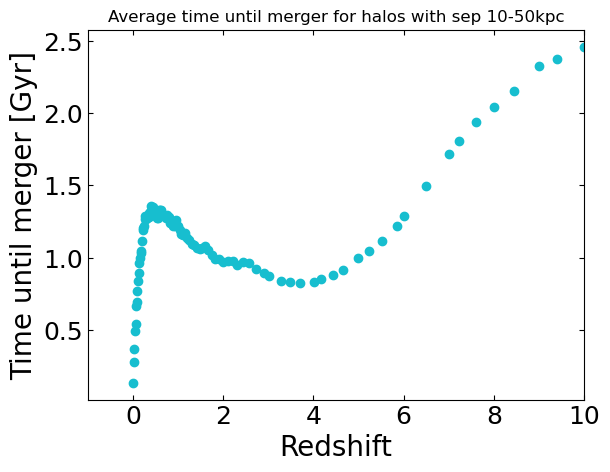

In [330]:
plt.scatter(convert['Redshift'],mean_time_til,color="tab:cyan")
# plt.plot(convert["Redshift"],2/(1+(convert["Redshift"]))**2,label=r"$C(1+z)^{-2}$",color="tab:olive")
plt.title("Average time until merger for halos with sep 10-50kpc",fontsize=12)
plt.xlim(right=10)
plt.xlabel("Redshift")
plt.ylabel("Time until merger [Gyr]")
plt.savefig("../../plots/bet-on-it/3_timeinbin_untilmerger_phys.png")

plt.show()





<font color='red'>could color the points by the fraction of things at that redshift that merge (two plots, one with only the fraction of things in 10-50 selected, and one with the total fraction at any sepeartion that merge, what fraction are within 10-50) 

also figure out where the artificial turn around point happens 




In [351]:
# first do it without the interpolated values & use ONLY the snapshot of interest
# next time do with interp and use some +/- value on either side of the redshift ~ 
mean_time_til_comov, std_time_til_comov = np.zeros((2,len(convert['Snapshot'])))

for i in convert['Snapshot']:
    in_bin = (interp_unique_low["SeparationsComoving"][:,i]<50)&(interp_unique_low["SeparationsComoving"][:,i]>10)&interp_unique_low['MergeFlag']
    
    
    merge_lbt = convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]
    time_to_merge = convert['Lookback Time'][i] - merge_lbt
    
    if len(merge_lbt)==0:
        mean_til = np.NaN
        std_til = np.NaN
    else:
        mean_til = np.mean(time_to_merge)
        std_til = np.std(std_in_bin)
    
    mean_time_til_comov[i] = mean_til
    std_time_til_comov[i] = std_til
    #print(mean_in_bin,std_in_bin)
    

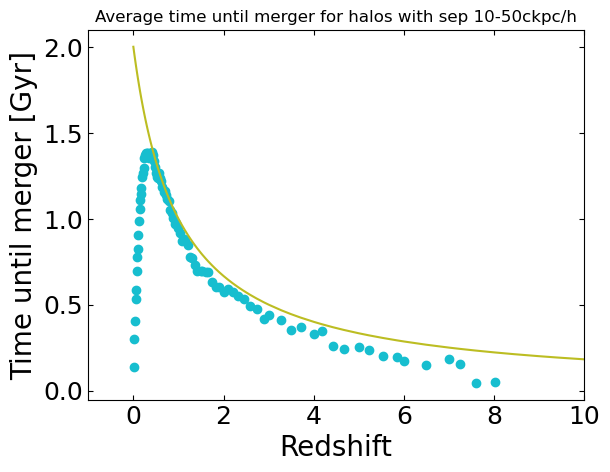

In [368]:
plt.scatter(convert['Redshift'],mean_time_til_comov,color="tab:cyan")
plt.plot(convert["Redshift"],2/(1+(convert["Redshift"]))**1,label=r"$C(1+z)^{-2}$",color="tab:olive")
plt.title("Average time until merger for halos with sep 10-50ckpc/h",fontsize=12)
plt.xlim(right=10)
plt.xlabel("Redshift")
plt.ylabel("Time until merger [Gyr]")
plt.savefig("../../plots/bet-on-it/3_timeinbin_untilmerger_comov.png")

plt.show()





## now to redo the above but using the interpolated data~

In [341]:
upper = 1.5
lower = 1.0
redshift_mask = (interp_convert['Redshift']<upper)&(interp_convert['Redshift']>lower)

(redshift_mask)

10000

In [349]:
np.sum((interp_unique_low['Separations Interp'][:,redshift_mask]>10)&(interp_unique_low['Separations Interp'][:,redshift_mask]<50))
 

2405004

In [ ]:
# first do it without the interpolated values & use ONLY the snapshot of interest
# next time do with interp and use some +/- value on either side of the redshift ~ 
mean_time_til, std_time_til = np.zeros((2,len(convert['Snapshot'])))

for i in convert['Redshift']:
    
    # define upper and lower redshift values to create mask
    if i == convert['Redshift'][0]:
        lower = i
        upper = i + 0.25
    elif i < 0.5:
        lower = i - 0.25
        upper = 0
    else: 
        lower = i - 0.25
        upper = i + 0.25
        
    # make redshift mask 
    redshift_mask = (interp_convert['Redshift']<upper)&(interp_convert['Redshift']>lower)
    
        
    interp_convert['Redshift']
    
    in_bin = (interp_unique_low['Separations Interp'][:,i]<50)&(interp_unique_low['Separations Interp'][:,i]>10)&interp_unique_low['MergeFlag']
    
    
    merge_lbt = convert["Lookback Time"][interp_unique_low['MergeSnapshot'][in_bin]]
    time_to_merge = convert['Lookback Time'][i] - merge_lbt
    
    if 1==0:
        mean_til = np.NaN
        std_til = np.NaN
    else:
        mean_til = np.mean(time_to_merge)
        std_til = np.std(std_in_bin)
    
    mean_time_til[i] = mean_til
    std_time_til[i] = std_til
    #print(mean_in_bin,std_in_bin)
    

## what about the amount of time until merger after the first entry into 10-50kpc bin ? 


In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(10,10),sharey=True, sharex='col', 
                       gridspec_kw={'width_ratios': [1,1], 
                                    'height_ratios':[1,1,1],
                                    'wspace': 0.04,
                                    "hspace":0.0})
z={"33":"z=2","40":"z=1.5","50":"z=1"}
little_h = 0.6774

for en,i in enumerate([low, high]):
    for ii, snap in enumerate([33, 40, 50]):
        orb = i[snap]
        sep_matrix = orb["Separations"]
        elapsed_time = np.abs(np.diff(convert["Lookback Time"]))
        scales = convert['Scale'] # gives scale in same order as orbit data

        scale_matrix = np.tile(scales,(len(sep_matrix),1))
        sep_ckpcperh = sep_matrix/scale_matrix*little_h

        # array of the elapsed time with a nan value in the place of z=0
        elapsed_noz0 = np.concatenate((elapsed_time,np.array([0])))
        elapsed_matrix = np.tile(elapsed_noz0,(len(sep_matrix),1))

        nan_elapsed = np.isnan(elapsed_matrix)
        nan_sep = np.isnan(sep_matrix)
        zero_sep = sep_matrix == 0
        lower_sep = sep_ckpcperh > 10
        matrix_mask = ~nan_elapsed&~nan_sep&~zero_sep&lower_sep

        merger_array = np.array(orb["MergeFlag"],dtype='bool')
        merge_mask = np.tile(merger_array,(100,1)).transpose()

    #     elapsed_masked = elapsed_matrix[matrix_mask]
    #     sep_masked = sep_matrix[matrix_mask]

        ## calculate histograms
        xx_phys = sep_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_phys_all = sep_matrix[matrix_mask&orb['GroupFlag']]


        xx_comov = sep_ckpcperh[matrix_mask&merge_mask&orb['GroupFlag']]
        xx_comov_all = sep_ckpcperh[matrix_mask&orb['GroupFlag']]

        yy = elapsed_matrix[matrix_mask&merge_mask&orb['GroupFlag']]
        yy_all = elapsed_matrix[matrix_mask&orb['GroupFlag']]

        num_mergers = sum(merger_array)
        num_pairs = len(merger_array) 
        bins_phys = np.arange(0,1000,20)
        bins_ckpch = np.arange(10,1500,20)

        phys, _ = np.histogram(xx_phys,bins=bins_phys,weights=yy/num_mergers)
        phys_all, _ = np.histogram(xx_phys_all,bins=bins_phys,weights=yy_all/num_pairs)
        comov, _ = np.histogram(xx_comov,bins=bins_ckpch,weights=yy/num_mergers)
        comov_all, _ = np.histogram(xx_comov_all,bins=bins_ckpch,weights=yy_all/num_pairs)    

        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2,alpha=0.15,fill=True,label="Mergers")
        ax[ii][en].stairs(np.cumsum(phys),bins_phys,color="darkolivegreen",lw=2)
        ax[ii][en].stairs(np.cumsum(phys_all),bins_phys,color="mediumturquoise",lw=2,label='All Pairs')

#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2,alpha=0.15,fill=True,label="Mergers")
#         ax[ii][1].stairs(np.cumsum(comov),bins_ckpch,color="tab:olive",lw=2)
#         ax[ii][1].stairs(np.cumsum(comov_all),bins_ckpch,color="tab:cyan",lw=2,label='All Pairs')

#         ax[ii][1].text(375,0.1,f"{z[str(snap)]}")


    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,alpha=0.15,fill=True)
    #     ax[ii].stairs(merged_vals,merged_edges,color="coral",lw=2,label="Merged")
    #     ax[ii].stairs(all_vals,all_edges,color="tab:cyan",lw=2,label="Group & lower phys sep",)
    # #     ax[ii].stairs(unmerged_vals,unmerged_edges,color="cornflowerblue",lw=2,label="Unmerged")

    #     ax[ii].text(0,1,f"{z[str(snap)]}")
    #     ax[ii].text(230,1.05,f"{(100*num_unmerged/num_pairs):.1f}%",color="cornflowerblue")
    #     ax[ii].text(100,0.2,f"{(100*num_mergers/num_pairs):.1f}%",color="coral")


    ax[0][0].set_title("Low Mass Pairs",fontsize=20)
    ax[0][1].set_title("High Mass Pairs",fontsize=20)

#     ax[2][0].set_xlabel("Separation [kpc]")
#     ax[2][1].set_xlabel("Comoving Separation [ckpc/h]")

#     ax[0][0].legend()
#     ax[0][1].legend()

#     ax[0][0].legend()
#     fig.suptitle("Total time with sep < S: Massive pairs")
    # fig.suptitle("Timescales for major dwarf pairs",y=0.92)
    fig.supxlabel("Separation S [kpc]",y=0.05)
#     fig.supylabel(r"$\left< \Delta T\right>_{pair}$ where $r_{sep}<S$ [Gyr]")
#     plt.savefig(f"{paths.path_plots}big-bad/cumulative-timevssep_z.pdf")
plt.show()


# Graveyard

## How long were things at 10-50 before they merged at this redshift? 

In [226]:
convert['Redshift'][22]

3.7087742646422353

The following plots show the AVERAGE amount of time that a subhalo pair spends with separations 10-50kpc for ONLY THE HALOS that merge at the given snapshot or in the next snapshot. 

For example, the point at z=4 is calculated by picking all pairs that merge at z=4 (snapshot 21) and at z=3.7 (snapshot 22), and taking the average of the total time they are in the 10-50 separation bin

In [312]:
elapsed = np.concatenate((np.abs(np.diff(interp_convert['Lookback Time Interp'])),[0]))
mean_times, std_times = np.zeros((2,len(snapmask)))

for en, i in enumerate(snapmask):
    mergers = np.where(np.isin(interp_unique_low['MergeSnapshot'],i))[0]
    #print('Number of mergers:',len(mergers))
    
    elapsed_in_bin = np.where(interp_unique_low['Separations Interp'][mergers]<50, np.where(interp_unique_low['Separations Interp'][mergers]>10, elapsed, 0), 0)
    if len(elapsed_in_bin)==0:
        mean_in_bin = np.NaN
        std_in_bin = np.NaN
    else:
        mean_in_bin = np.mean(np.sum(elapsed_in_bin,axis=1))
        std_in_bin = np.std(np.sum(elapsed_in_bin,axis=1))
    
    mean_times[en] = mean_in_bin
    std_times[en] = std_in_bin
    #print(mean_in_bin,std_in_bin)
    

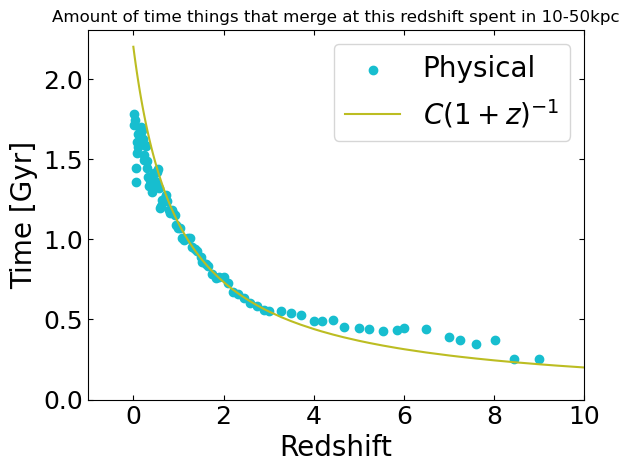

In [324]:
plt.scatter(convert['Redshift'][:-1],mean_times,color="tab:cyan",label='Physical')
plt.plot(convert["Redshift"],2.2/(1+(convert["Redshift"]))**1,label=r"$C(1+z)^{-1}$",color="tab:olive")
plt.xlim(right=10)
plt.title("Amount of time things that merge at this redshift spent in 10-50kpc",fontsize=12)
plt.ylabel("Time [Gyr]")
plt.xlabel('Redshift')
plt.legend()
plt.savefig("../../plots/bet-on-it/3_timeinbin_beforemerger.png")
plt.show()


this is suspiciously the same form as the scale, so let me try with the comoving distances

## Same as above comoving

In [326]:
elapsed = np.concatenate((np.abs(np.diff(interp_convert['Lookback Time Interp'])),[0]))
mean_times_comov, std_times_comov = np.zeros((2,len(snapmask)))

for en, i in enumerate(snapmask):
    mergers = np.where(np.isin(interp_unique_low['MergeSnapshot'],i))[0]
    #print('Number of mergers:',len(mergers))
    
    elapsed_in_bin = np.where(interp_unique_low['SeparationsComoving Interp'][mergers]<50, np.where(interp_unique_low['SeparationsComoving Interp'][mergers]>10, elapsed, 0), 0)
    if len(elapsed_in_bin)==0:
        mean_in_bin = np.NaN
        std_in_bin = np.NaN
    else:
        mean_in_bin = np.mean(np.sum(elapsed_in_bin,axis=1))
        std_in_bin = np.std(np.sum(elapsed_in_bin,axis=1))
    
    mean_times_comov[en] = mean_in_bin
    std_times_comov[en] = std_in_bin
    #print(mean_in_bin,std_in_bin)
    

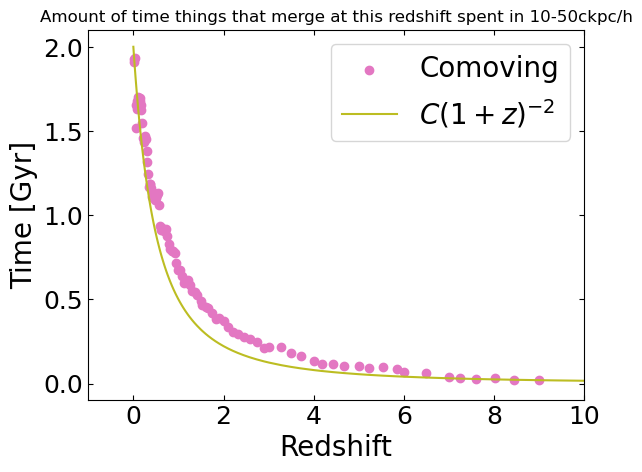

In [329]:

plt.scatter(convert['Redshift'][:-1],mean_times_comov,color="tab:pink",label="Comoving")
plt.plot(convert["Redshift"],2/(1+(convert["Redshift"]))**2,label=r"$C(1+z)^{-2}$",color="tab:olive")
plt.xlim(right=10)
plt.title("Amount of time things that merge at this redshift spent in 10-50ckpc/h",fontsize=12)
plt.ylabel("Time [Gyr]")
plt.xlabel('Redshift')
plt.legend()
plt.savefig("../../plots/bet-on-it/3_timeinbin_beforemerger_comov.png")
plt.show()

